In [113]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.offline as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=False)
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import word2vec
import nltk
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Great Learning/NLP/results/ZOMATO (2).CSV')

## **Basic Understanding the data:**

In [4]:
print('The size of the data set :',df.shape)

The size of the data set : (51717, 18)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   51717 non-null  int64 
 1   url                          51717 non-null  object
 2   address                      51717 non-null  object
 3   name                         51717 non-null  object
 4   online_order                 51717 non-null  object
 5   book_table                   51717 non-null  object
 6   rate                         43942 non-null  object
 7   votes                        51717 non-null  int64 
 8   phone                        50509 non-null  object
 9   location                     51696 non-null  object
 10  rest_type                    51490 non-null  object
 11  dish_liked                   23639 non-null  object
 12  cuisines                     51672 non-null  object
 13  approx_cost(for two people)  51

In [6]:
df.head()

Unnamed: 0  ... listed_in(city)
0           0  ...    Banashankari
1           1  ...    Banashankari
2           2  ...    Banashankari
3           3  ...    Banashankari
4           4  ...    Banashankari

[5 rows x 18 columns]

# **Exploratory Data analysis:**

Which are the top restaurant chains in Bangaluru?

Text(0.5, 0, 'Number of outlets')

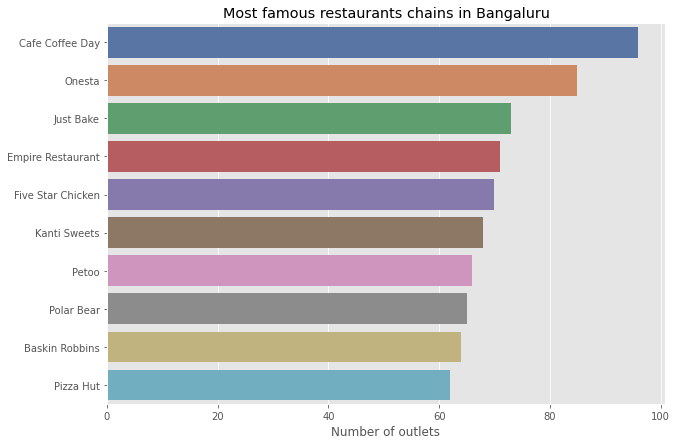

In [7]:
plt.figure(figsize=(10,7))
chains=df['name'].value_counts()[:10]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Most famous restaurants chains in Bangaluru")
plt.xlabel("Number of outlets")

We can see the above plot showing top 10 restaurant


## **How many of the restuarants do not accept online orders?**


In [8]:
offline = df[df['online_order'] == 'No']['name']

Text(0.5, 0, 'Number of outlets')

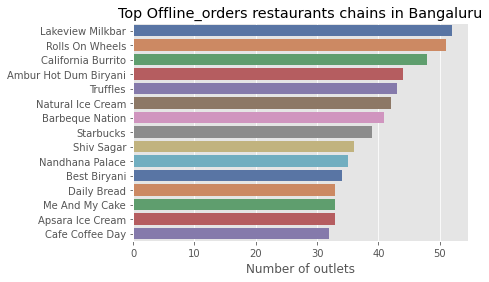

In [9]:
off_names = offline.value_counts()[:15]
sns.barplot(x=off_names,y=off_names.index,palette='deep')
plt.title("Top Offline_orders restaurants chains in Bangaluru")
plt.xlabel("Number of outlets")

From the above plot we can see the top 15 restaurants in Bangalore

# **Online and Offline orders restaurants percentage:**

In [10]:
n  = len(df)
online_size = df[df['online_order'] == 'Yes'].shape[0]
offline_size = df[df['online_order'] == 'No'].shape[0]

In [11]:
print('The online order restaurants percentage:',round(online_size/n*100))
print('The offline order restaurants percentage:',round(offline_size/n*100))

The online order restaurants percentage: 59
The offline order restaurants percentage: 41


- We can see that * 59 percentage restaurants are choosing online orders and * 41 percentage restaurants are not choosing online orders.
- This might be because of the fact that these restaurants cannot afford to pay commission to zomoto for giving them orders online. zomato may want to consider giving them some more benefits if they want to increse the number of restaurants serving their customers online.


**What is the ratio b/w restaurants that provide and do not provide table booking**

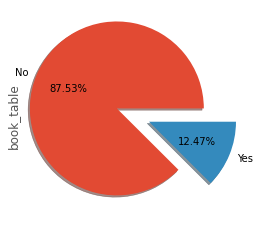

In [20]:
df['book_table'].value_counts(normalize = True).plot(kind='pie',autopct='%.2f%%',explode=[0.2,0.2],shadow = True)

1. Almost 90 percent of restaurants in Banglore do not provide table booking facility.
2. In India you cannot find table booking facility in any average restaurants,usually only five star restaurants provides table booking.


# ***Rating distribution***

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



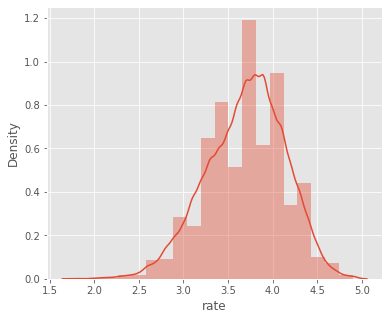

In [23]:
plt.figure(figsize=(6,5))
rating=df['rate'].dropna().apply(lambda x : float(x.split('/')[0]) if (len(x)>3)  else np.nan ).dropna()
sns.distplot(rating,bins=20)
plt.show()

1. Almost more than 50 percent of restaurants has rating between 3 and 4.
2. Restaurants having rating more than 4.5 are very rare.

In [24]:
cost_dist=df[['rate','approx_cost(for two people)','online_order']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)
cost_dist['approx_cost(for two people)']=cost_dist['approx_cost(for two people)'].apply(lambda x: int(x.replace(',','')))

# **Cost vs rating**

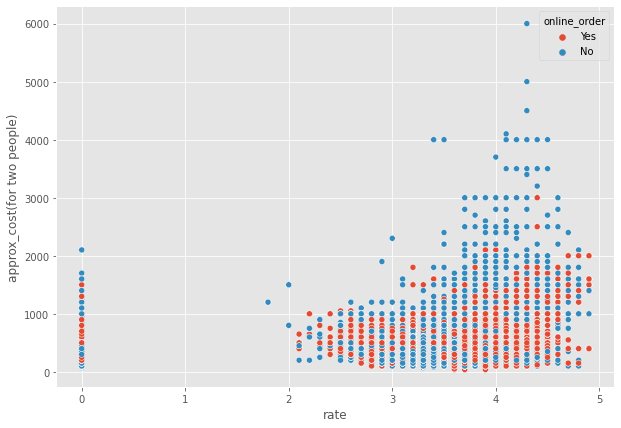

In [25]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="rate",y='approx_cost(for two people)',hue='online_order',data=cost_dist)
plt.show()

1. We can see the Restaurant do not accept the online order having more price.

# ***Distribution of cost for two people***

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



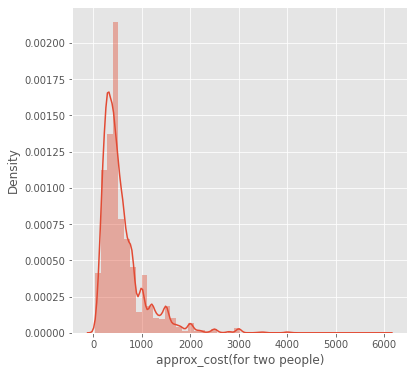

In [26]:
plt.figure(figsize=(6,6))
sns.distplot(cost_dist['approx_cost(for two people)'])
plt.show()

1. We can see that the distribution if left skewed.
2. This means almost 90percent of restaurants serve food for budget less than 1000 INR.($15)

Is there any difference b/w votes of restaurants accepting and not accepting online orders?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



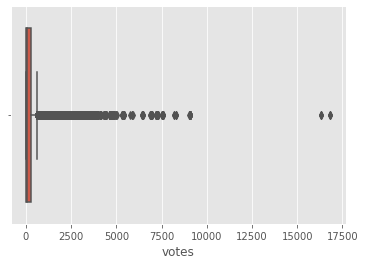

In [36]:
votes_yes=df[df['online_order']=="Yes"]['votes']
sns.boxplot(votes_yes)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



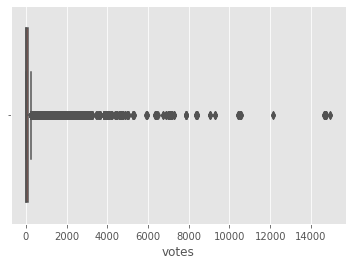

In [37]:
votes_no=df[df['online_order']=="No"]['votes']
sns.boxplot(votes_no)

**Which are the most common restaurant type in Banglore?**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



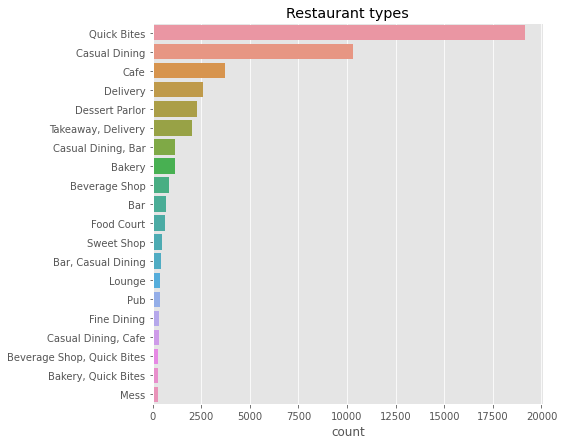

In [30]:
plt.figure(figsize=(7,7))
rest=df['rest_type'].value_counts()[:20]
sns.barplot(rest,rest.index)
plt.title("Restaurant types")
plt.xlabel("count")
plt.show()

We can see that Quick Bites is the most preferable item in bangalore.

# ***Cost factor ?***





In [59]:
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(',','').astype(float)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



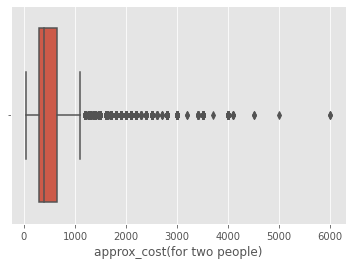

In [60]:
sns.boxplot(df['approx_cost(for two people)'])
plt.show()

1. The median approximate cost for two people is 400 for a single meal.
2. 50 percent of restaurants charge between 300 and 650 for single meal for two people.


# ***Finding Best budget Restaurants in any location***

In [61]:
cost_dist=df[['rate','approx_cost(for two people)','location','name','rest_type']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)

In [62]:
def return_budget(location,rest):
    budget=cost_dist[(cost_dist['approx_cost(for two people)']<=400) & (cost_dist['location']==location) & 
                     (cost_dist['rate']>4) & (cost_dist['rest_type']==rest)]
    return(budget['name'].unique())

In [63]:
return_budget('BTM',"Quick Bites")

array(['Swadista Aahar', 'Litti Twist', 'The Shawarma Shop', 'Gorbandh',
       'Yum In My Tum', 'Chaatimes', "Muthashy's", 'Swad Punjab Da',
       "Domino's Pizza", 'Roti Wala', 'Andhra Kitchen'], dtype=object)

## ***Which are the foodie areas?***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



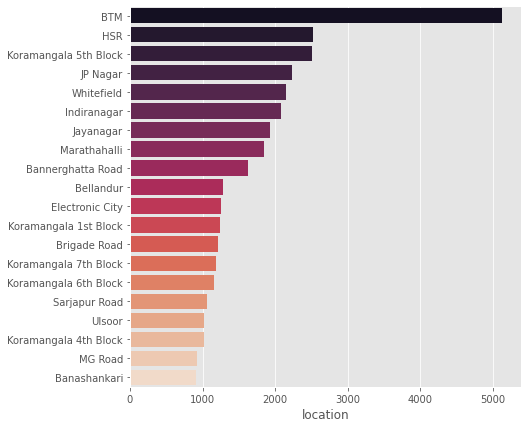

In [64]:
plt.figure(figsize=(7,7))
Rest_locations=df['location'].value_counts()[:20]
sns.barplot(Rest_locations,Rest_locations.index,palette="rocket")

1. We can see that **BTM,HSR and Koranmangala 5th block** has the most number of restaurants.
2. BTM dominates the section by having more than 5000 restaurants.

# **Which are the most common cuisines in each locations**

In [65]:
df_1=df.groupby(['location','cuisines']).agg('count')
data=df_1.sort_values(['url'],ascending=False).groupby(['location'],
                as_index=False).apply(lambda x : x.sort_values(by="url",ascending=False).head(3))['url'].reset_index().rename(columns={'url':'count'})


In [66]:
data.head(10)

level_0           location               cuisines  count
0        0                BTM  North Indian, Chinese    379
1        0                BTM           North Indian    340
2        0                BTM                Biryani    120
3        1       Banashankari           South Indian     86
4        1       Banashankari  North Indian, Chinese     61
5        1       Banashankari           North Indian     36
6        2          Banaswadi           South Indian     37
7        2          Banaswadi  North Indian, Chinese     24
8        2          Banaswadi                Biryani     23
9        3  Bannerghatta Road  North Indian, Chinese    130

# ***Which are  the most popular cuisines of Bangalore?***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Most popular cuisines of Bangalore')

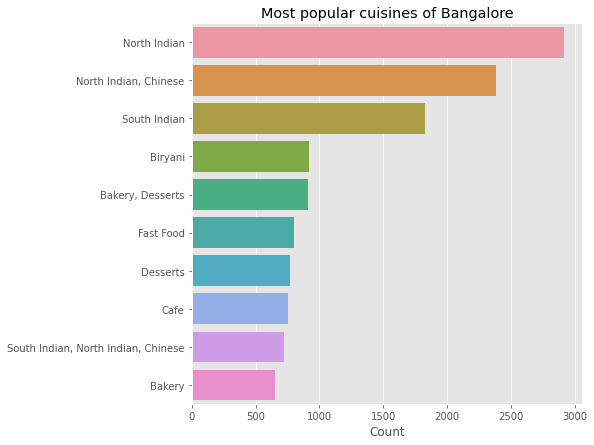

In [67]:
plt.figure(figsize=(7,7))
cuisines=df['cuisines'].value_counts()[:10]
sns.barplot(cuisines,cuisines.index)
plt.xlabel('Count')
plt.title("Most popular cuisines of Bangalore")

1. We can observe that **North Indian,chinese,South Indian and Biriyani** are most common.
2. Is this imply the fact that Banglore is more influenced by North Indian culture more than South?

# ***Which are the most popular casual dining restaurant chains?***

In [84]:
casual=df[df['rest_type']=='Casual Dining']
top_casual_dining = casual['name'].value_counts()[:15]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



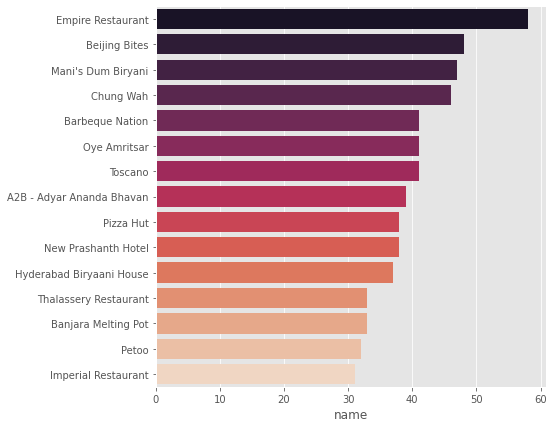

In [86]:
plt.figure(figsize=(7,7))
sns.barplot(top_casual_dining,top_casual_dining.index,palette="rocket")

- We can see tht **Empire restaurant,Beijing bites and Mani's dum biriyani** are the most popular casual dining restaurant chains in Bangalore.

# ***Top quick bites restaurant chains in Banglore***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Count')

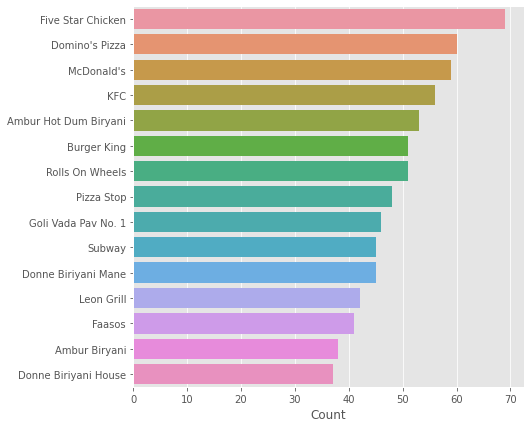

In [87]:
plt.figure(figsize=(7,7))
quick_bites=df[df['rest_type']=='Quick Bites']
top_quick_bites = quick_bites['name'].value_counts()[:15]
sns.barplot(top_quick_bites,top_quick_bites.index)
plt.xlabel('Count')

- Surprisingly  ** Five star chicken** dominates in quick bites restaurant types overtaking famous **Domino's Pizza and McDonald's**.
- Five Star Chicken is a branch of Charoen Pokphand Group Foods, a Thai multinational conglomerate with over $12 billion business in Agro and Food       Industries. Five Star Chicken specialties in fried chicken.

## ***Top Cafes of Banglore?***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Count')

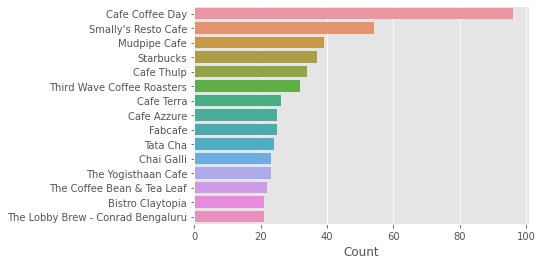

In [88]:
cafe = df[df['rest_type'] == 'Cafe']
top_cafe = cafe['name'].value_counts()[:15]
sns.barplot(top_cafe,top_cafe.index)
plt.xlabel('Count')

- No surprises,Cafe coffee day restaurant dominated way over other cafe chains in Banglore.
- Cafe coffee day has 96 outlets in Banglore.
- Café Coffee Day was started as a retail restaurant in 1996. The first CCD outlet was set up on July 11, 1996, at Brigade Road, Bengaluru, Karnataka.


## ***Wordcloud of dishes liked by cuisines.***

In [89]:
df['dish_liked']

0        Pasta, Lunch Buffet, Masala Papad, Paneer Laja...
1        Momos, Lunch Buffet, Chocolate Nirvana, Thai G...
2        Churros, Cannelloni, Minestrone Soup, Hot Choc...
3                                              Masala Dosa
4                                      Panipuri, Gol Gappe
                               ...                        
51712                                                  NaN
51713                                                  NaN
51714                                                  NaN
51715                         Cocktails, Pizza, Buttermilk
51716                                                  NaN
Name: dish_liked, Length: 51717, dtype: object

In [90]:
df['dish_liked']=df['dish_liked'].apply(lambda x : x.split(',') if type(x)==str else [''])

In [91]:
df['dish_liked']

0        [Pasta,  Lunch Buffet,  Masala Papad,  Paneer ...
1        [Momos,  Lunch Buffet,  Chocolate Nirvana,  Th...
2        [Churros,  Cannelloni,  Minestrone Soup,  Hot ...
3                                            [Masala Dosa]
4                                   [Panipuri,  Gol Gappe]
                               ...                        
51712                                                   []
51713                                                   []
51714                                                   []
51715                     [Cocktails,  Pizza,  Buttermilk]
51716                                                   []
Name: dish_liked, Length: 51717, dtype: object

In [92]:
rest=df['rest_type'].value_counts()[:9].index
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=df[df['rest_type']==r]['dish_liked'].values.tolist()
        corpus=','.join(x  for list_words in corpus for x in list_words)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        

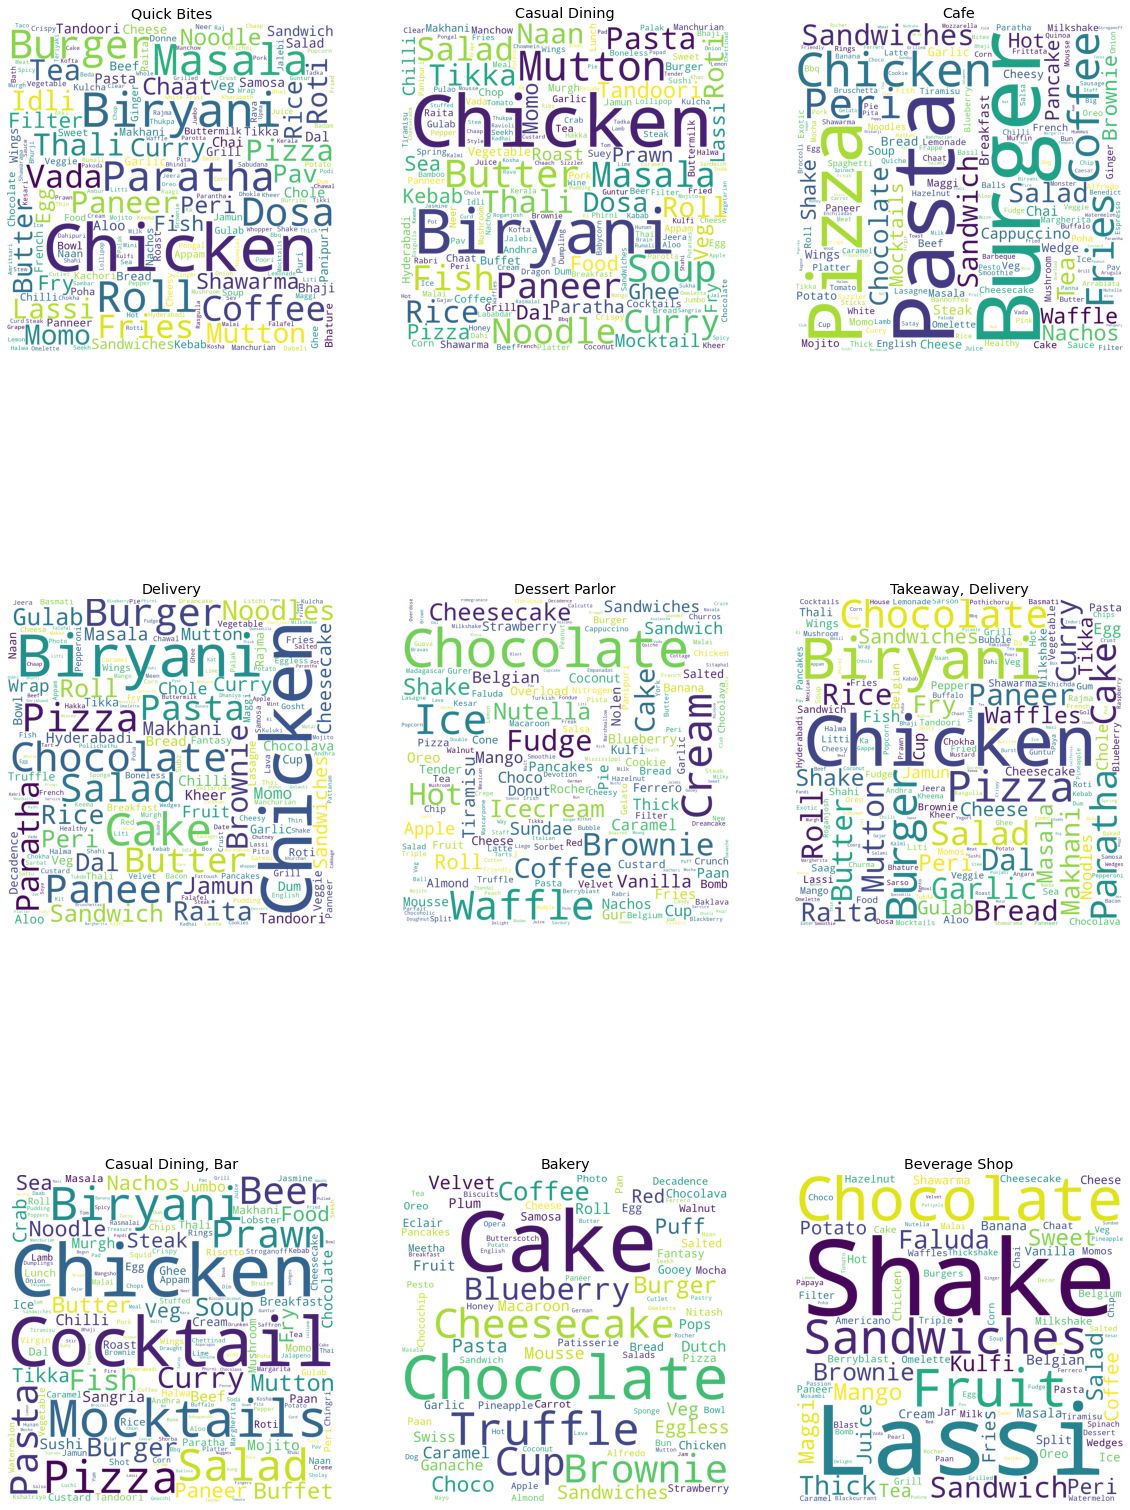

In [93]:
produce_wordcloud(rest)

# ***Analysing Reviews***

- We will extract reviews and ratings of each restaurant and create a dataframe with it.

In [104]:
all_ratings = []

for name,ratings in tqdm(zip(df['name'],df['reviews_list'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name,score, doc])

51717it [00:25, 2004.82it/s]


In [107]:
all_ratings[:5]

[['Jalsa',
  4.0,
  'A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only limited items available. But the taste and service was not compromised at all.The only complaint is that the breads could have been better.Would surely like to come here again.'],
 ['Jalsa',
  4.0,
  'I was here for dinner with my family on a weekday. The restaurant was completely empty. Ambience is good with some good old hindi music. Seating arrangement are good too. We ordered masala papad, panner and baby corn starters, lemon and corrionder soup, butter roti, olive and chilli paratha. Food was fresh and good, service is good too. Good for family hangout.\nCheers'],
 ['Jalsa',
  2.0,
  'Its a restaurant near to Banashankari BDA. Me along with few of my office friends visited to have buffet but unfortunately they only provide veg buffet. On inquiring they said this place is mostly visited by veg

In [105]:
rating_df=pd.DataFrame(all_ratings,columns=['name','rating','review'])
rating_df['review']=rating_df['review'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))

In [108]:
rating_df.head()

name  rating                                             review
0  Jalsa     4.0  A beautiful place to dine inThe interiors take...
1  Jalsa     4.0  I was here for dinner with my family on a week...
2  Jalsa     2.0  Its a restaurant near to Banashankari BDA Me a...
3  Jalsa     4.0  We went here on a weekend and one of us had th...
4  Jalsa     5.0  The best thing about the place is its ambiance...

# ***WordCloud of Reviews of restaurant chains***

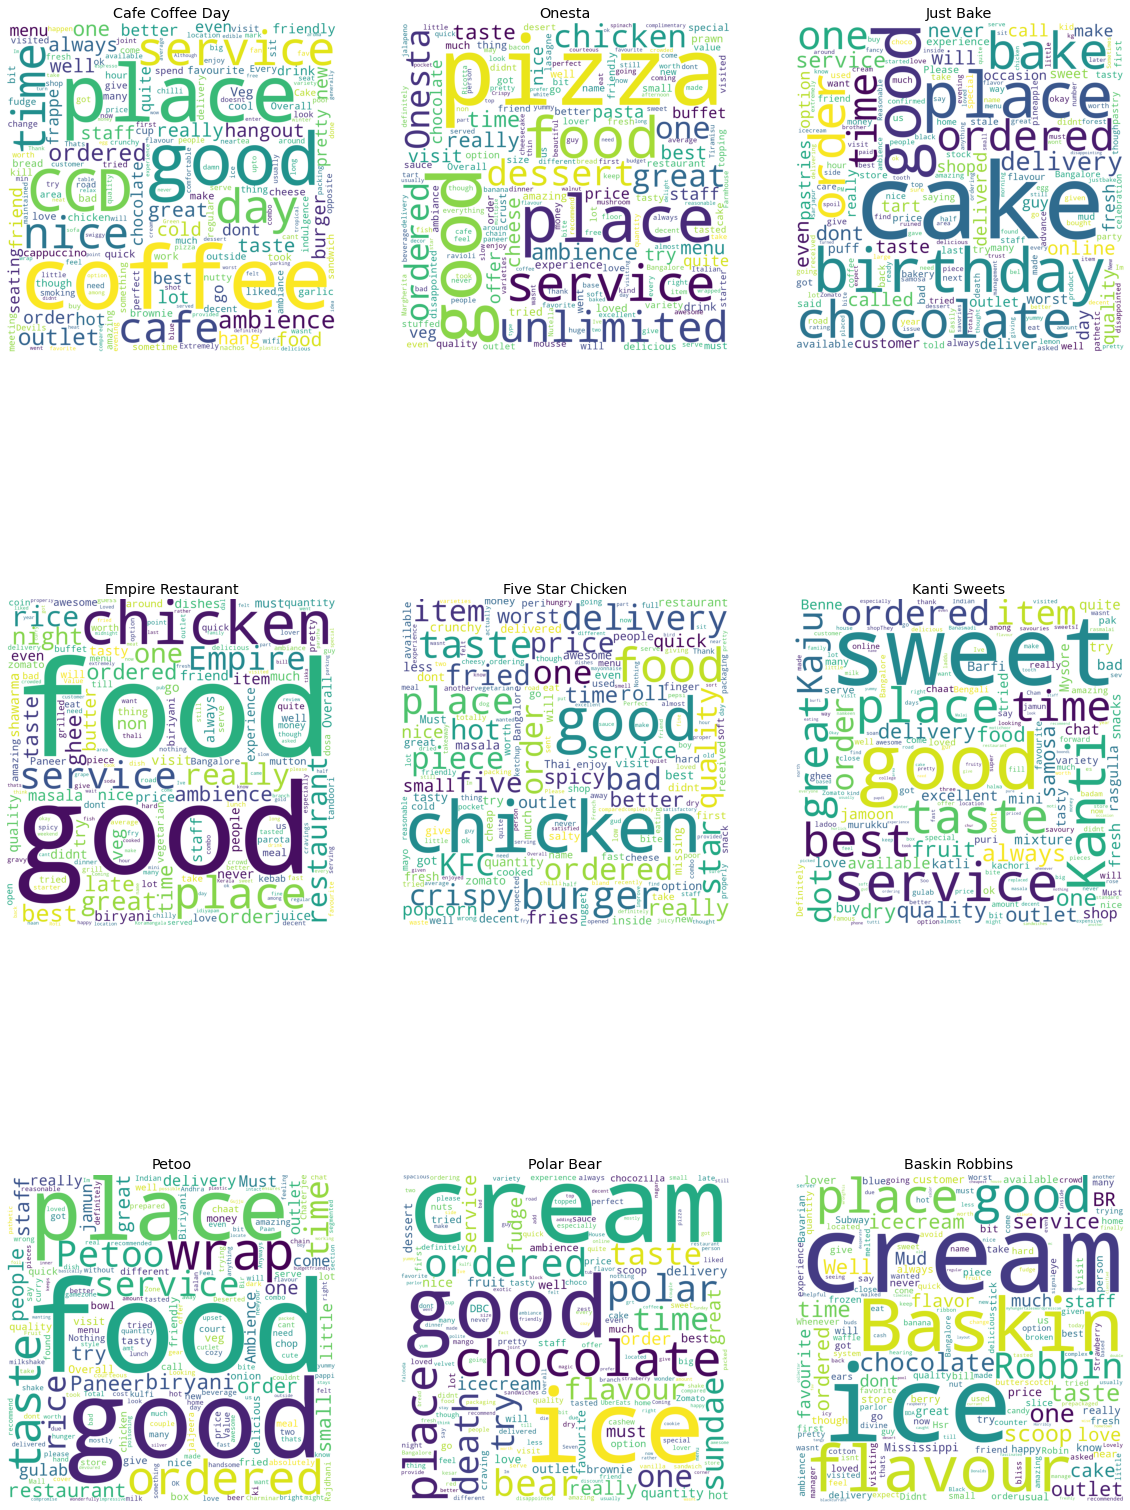

In [109]:
rest=df['name'].value_counts()[:9].index
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=rating_df[rating_df['name']==r]['review'].values.tolist()
        corpus=' '.join(x  for x in corpus)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        

        
        
produce_wordcloud(rest)

# ***Rating distribution***

Text(0, 0.5, 'count')

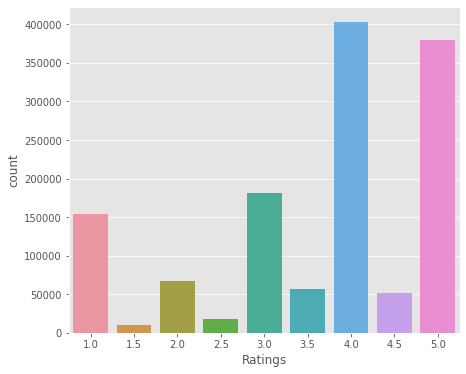

In [110]:
plt.figure(figsize=(7,6))
rating=rating_df['rating'].value_counts()
sns.barplot(x=rating.index,y=rating)
plt.xlabel("Ratings")
plt.ylabel('count')

# ***Model Bulding:***

## ***Data Preprocessing:***

In [111]:
rating_df.head()

name  rating                                             review
0  Jalsa     4.0  A beautiful place to dine inThe interiors take...
1  Jalsa     4.0  I was here for dinner with my family on a week...
2  Jalsa     2.0  Its a restaurant near to Banashankari BDA Me a...
3  Jalsa     4.0  We went here on a weekend and one of us had th...
4  Jalsa     5.0  The best thing about the place is its ambiance...

In [116]:
rating_df['Sentiment'] = rating_df['rating'].apply(lambda x: 'Positive' if x>2.5 else 'Negative')

# ***Distribution of the Sentiment***

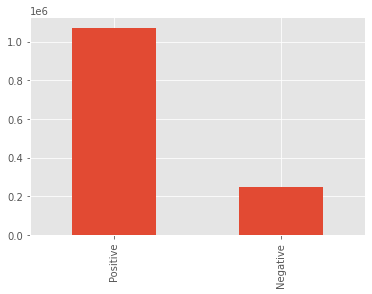

In [117]:
rating_df['Sentiment'].value_counts().plot(kind = 'bar')

In [120]:
rating_df.shape

(1319968, 4)

In [125]:
sample_rating = rating_df.sample(frac=.20,random_state = 10)

In [126]:
sample_rating.shape

(263994, 4)

In [128]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [141]:
stops=stopwords.words('english')
stops.remove('no')
stops.remove('not')

In [134]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [145]:

import re, string

def clean_str(string):      
    words = string.strip().lower().split()    
    words = [w for w in words if len(w)>=1]
    words = [w for w in words if w not in stops]
    return " ".join(words)

In [148]:
sample_rating['clean_review'] = sample_rating['review'].apply(clean_str)
rating_df.head()

name  rating  ... Sentiment                                       clean_review
0  Jalsa     4.0  ...  Positive  beautiful place dine inthe interiors take back...
1  Jalsa     4.0  ...  Positive  dinner family weekday restaurant completely em...
2  Jalsa     2.0  ...  Negative  restaurant near banashankari bda along office ...
3  Jalsa     4.0  ...  Positive  went weekend one us buffet two us took ala car...
4  Jalsa     5.0  ...  Positive  best thing place ambiance second best thing yu...

[5 rows x 5 columns]

In [147]:
def lem(text):
    lem=WordNetLemmatizer()
    text = ' '.join([lem.lemmatize(word) for word in text.split()])
    return text

In [149]:
sample_rating['clean_review'] =  sample_rating['clean_review'].apply(lem)

In [150]:
sample_rating.head()

name  ...                                       clean_review
363559             The Rasoiya Street  ...  nice place located hsr layout menu vast indian...
83672   Tipsy Bull - The Bar Exchange  ...  good place want booze okayish food better orde...
317496                        Navab's  ...  cook leave decided order navabs ordered shabha...
878732          Mr. Beans - Home Cafe  ...  nice little place chat enjoy evening light mus...
319609                  Pind Balluchi  ...  pind balluchi name enough famous serving quali...

[5 rows x 5 columns]

# ***Data Spliting:***

In [151]:
X = sample_rating['clean_review']
y = sample_rating['Sentiment']

In [152]:
y = pd.get_dummies(y,drop_first=True)

In [153]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state=10)

In [154]:
tfidf = TfidfVectorizer(ngram_range=(2,2))
tfidf.fit(X_train)
X_train_tfidf =tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [155]:
from nltk.probability import FreqDist
from scipy.stats import itemfreq
from nltk.tokenize import word_tokenize

In [156]:
words_token = []
for i in X_train:
    words = word_tokenize(i)
    words_token.extend(words)

In [157]:
fdist = FreqDist(words_token)

In [158]:
fdist.most_common()[:20]

[('place', 162133),
 ('food', 155608),
 ('good', 150766),
 ('not', 73969),
 ('chicken', 64873),
 ('service', 63250),
 ('ordered', 50201),
 ('ambience', 49347),
 ('taste', 47138),
 ('one', 45453),
 ('great', 44806),
 ('time', 42714),
 ('really', 40193),
 ('also', 37252),
 ('try', 36996),
 ('nice', 34532),
 ('like', 32678),
 ('visit', 30958),
 ('staff', 30279),
 ('best', 30172)]

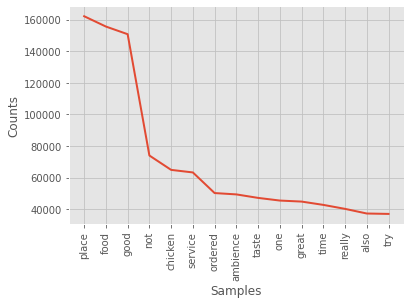

In [159]:
fdist.plot(15)

In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve,roc_auc_score

In [162]:
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [164]:
y_pred = lr_model.predict(X_test_tfidf)

In [179]:
y_pred_proba = lr_model.predict_proba(X_test_tfidf)[:,1]

In [180]:
y_pred_proba

array([0.34468617, 0.97045844, 0.99203317, ..., 0.95143333, 0.93252513,
       0.99117797])

In [166]:
metrics.accuracy_score(y_test,y_pred)

0.9503399685600106

In [186]:
def roc_results(y_pred_proba):
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred_proba)
  auc_score = roc_auc_score(y_test, y_pred_proba)
  plt.plot(false_positive_rate, true_positive_rate, label='AUC %0.2f'% (auc_score))
  plt.title('Classifiers comparaison with ROC')
  plt.legend(loc='lower right')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([-0.1,1.2])
  plt.ylim([-0.1,1.2])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

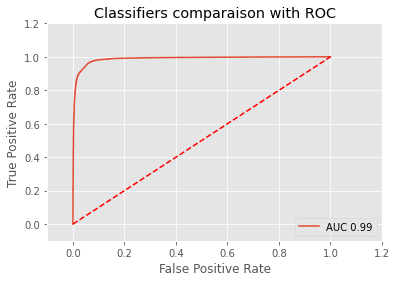

In [187]:
roc_results(y_pred_proba)

In [192]:
print('CLASSIFICATION REPORT for train:')
print(metrics.classification_report(y_train,lr_model.predict(X_train_tfidf)))

CLASSIFICATION REPORT for train:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     39698
           1       0.96      1.00      0.98    171497

    accuracy                           0.97    211195
   macro avg       0.97      0.92      0.94    211195
weighted avg       0.97      0.97      0.96    211195



In [193]:
print('CLASSIFICATION REPORT for test:')
print(metrics.classification_report(y_test,y_pred))

CLASSIFICATION REPORT for test:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      9970
           1       0.95      0.99      0.97     42829

    accuracy                           0.95     52799
   macro avg       0.95      0.88      0.91     52799
weighted avg       0.95      0.95      0.95     52799



In [189]:
BNB_model = BernoulliNB()

In [194]:
BNB_model.fit(X_train_tfidf,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



BernoulliNB()

In [195]:
y_pred_BNB = BNB_model.predict(X_test_tfidf)

In [197]:
print('Accuracy score :',metrics.accuracy_score(y_test,y_pred_BNB))

Accuracy score : 0.9321199265137597


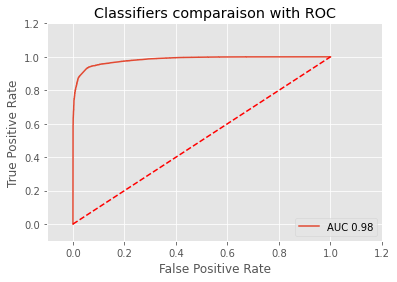

In [199]:
roc_results(BNB_model.predict_proba(X_test_tfidf)[:,1])

In [200]:
from sklearn.naive_bayes import MultinomialNB

In [201]:
MNB_model = MultinomialNB()

In [202]:
MNB_model.fit(X_train_tfidf,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MultinomialNB()

In [204]:
y_pred_MNB = MNB_model.predict(X_test_tfidf)

In [206]:
print('Accuracy for MNB',metrics.accuracy_score(y_test,y_pred_MNB))

Accuracy for MNB 0.9398852250989602


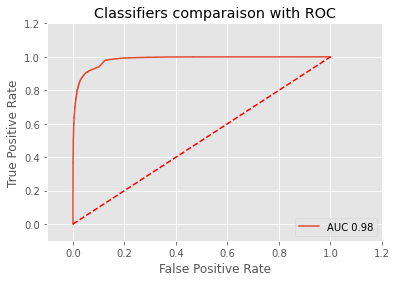

In [207]:
roc_results(MNB_model.predict_proba(X_test_tfidf)[:,1])

I have choosen the accuracy as the metrics

We can see that Logistic model is giving best accuracy comparing the other models so I choosen the Logistic model has Final model.

Logistics Regression


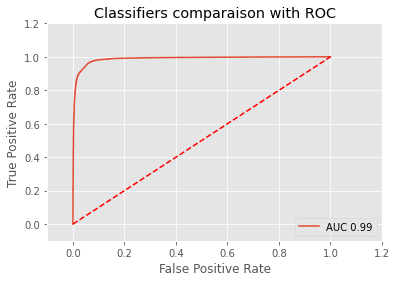

In [210]:
print('Logistics Regression')
roc_results(y_pred_proba)

In [211]:
print('Accuracy for Logistic Regression:',metrics.accuracy_score(y_test,y_pred))

Accuracy for Logistic Regression: 0.9503399685600106
